**I) Importing the libraries**

In [0]:
import gcsfs
import xarray as xr
import zarr

%matplotlib inline
%pylab inline

from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
%%bash
apt-get install libgeos-3* libgeos-dev
pip install https://github.com/matplotlib/basemap/archive/master.zip

In [0]:
#import
fs = gcsfs.GCSFileSystem(project="alert-ground-261008")
gcsmap = fs.get_mapper("opendata_bdo2020/EN.4.2.1.f.analysis.g10.zarr")
ds = xr.open_zarr(gcsmap)

**II) Calculation of the Ocean Heat Content**

In [0]:
R = 6371*10**3 #km
cp = 3850 #Joule par kg par K
rho = 1025 #kg par m3

lon = ds['lon'].values
lat = ds['lat'].values

#Lon, Lat = np.meshgrid(lon,lat)

Z = ds['depth']
T = ds['temperature']

#Computation of dx
dx=np.zeros((len(lon),len(lat)))
for i in range(len(lon)-1) :
  for j in range(len(lat)-1) :
    dx[i,j] = R*np.cos(0.5*(lat[j+1]-lat[j])*np.pi/180)*(lon[i+1]-lon[i])*np.pi/180
dx[-1,-1] = R*np.cos(0.5*(lat[-1]-lat[-2])*np.pi/180)*(lon[-1]-lon[-2])*np.pi/180

#Computation of dy
dy=np.zeros(len(lat))
for i in range(len(lat)-1) :
  dy[i] = R*(lat[i+1]-lat[i])*np.pi/180
dy[-1] = R*(lat[-1]-lat[-2])*np.pi/180

#Computation of dz
dz=np.zeros(len(Z))
for i in range(len(Z)-1) :
  dz[i] = (Z.values[i+1]-Z.values[i])
dz[-1]=(Z.values[-1]-Z.values[-2])

In [0]:
#Transformation into a DataArray
deltax = xr.DataArray(dx, dims=('lon', 'lat'), coords={'lon': ds['lon'], 'lat': ds['lat']})
deltay = xr.DataArray(dy, dims=('lat'), coords={'lat': ds['lat']})
deltaz = xr.DataArray(dz, dims=('depth'), coords={'depth': ds['depth']})

In [0]:
mydata = deltax.to_dataset(name='dx')
mydata['dy'] = deltay
mydata['dz'] = deltaz
mydata['T'] = T

integral = mydata['dy']*mydata['dz']*mydata['T']*mydata['dx']

#Computation of OHC
OHC = rho*cp*integral.sum(axis=0).sum(axis=0).sum(axis=1)

#Mean without the 1981-2010 baseline, and transformation into ZJ
OHCmean = (OHC-OHC.sel(time=slice('1981','2010')).mean())*10**(-21)

In [0]:
#Creation of a dataframe with all the dates of the dataset
df = ds['time'].to_dataframe()
df['newTime'] = None #Creation of a new column, which is empty

In [0]:
#Conversion into Julian Date
for i in range(len(df['time'])):
  df['newTime'][i] = int(df['time'][i].to_julian_date())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
nTime = np.arange(df['newTime'][0],df['newTime'][831]+29496,np.diff(df['newTime'])[0]).astype(int)
time3 = pd.to_datetime(nTime,origin='julian',unit='D') #dataframe of dates until 2100
time2 = pd.to_datetime(df['newTime'],origin='julian',unit='D') #dataframe of dates from the dataset only

In [0]:
df2= pd.DataFrame(time3.to_julian_date(),columns=["julian"])

In [0]:
#Creation of a SVR model
model = SVR(C=300,epsilon=0.1)
model.fit(df['newTime'][:,None],OHCmean)

y_hat=model.predict(df['newTime'][:,None])
y_hat2 = model.predict(time3.to_julian_date()[:,None])

In [0]:
#RMSE for SVR
rmse = sqrt(mean_squared_error(OHCmean, y_hat))

In [0]:
# 1 : creation of the polynomial and its coefficients
#Polynomial linear regression
t = df['newTime']
x1 = t
x2 = t**2
x3 = t**3
X = np.vstack((x1,x2,x3)).T

#Initialization of polynomial coefficients
a1=1
a2=1
a3=1
b=1

# 2 : creation of the model
model = LinearRegression()

# 3: fit the model, as before
model.fit(X,OHCmean)
ylinear = model.predict(X)

In [0]:
print('Model coefficients for [a1, a2, a3]: {}'.format(model.coef_))
print('Model coefficient for b: {}'.format(model.intercept_))
#New values of the coefficients
a1 = model.coef_[0]
a2 = model.coef_[1]
a3 = model.coef_[2]
b = model.intercept_

# f is our fonction representing our polynomial
def f(x):
  return b + a1*x + a2*x**2 + a3*x**3

Model coefficients for [a1, a2, a3]: [-6.43711391e-13 -1.57447563e-06  4.29922501e-13]
Model coefficient for b: 3128295.0435814224


In [0]:
#RMSE for the polynomial model
rmse_pol = sqrt(mean_squared_error(OHCmean, ylinear))

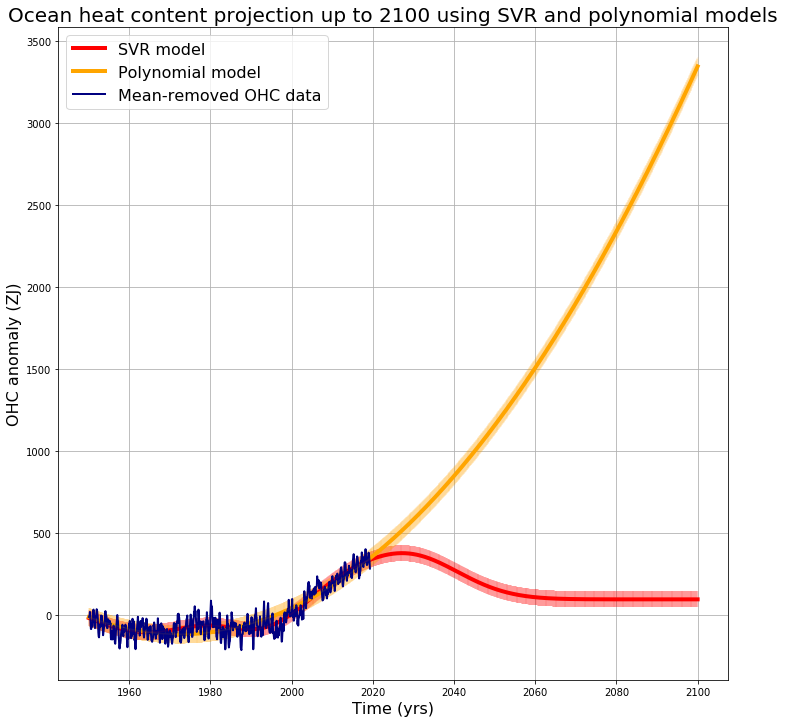

In [0]:
plt.figure(figsize=(12,12))
plt.xlabel('Time (yrs)',fontsize=16)
plt.ylabel('OHC anomaly (ZJ)',fontsize=16)
plt.title('Ocean heat content projection up to 2100 using SVR and polynomial models', fontsize=20)


plt.plot(time3, y_hat2,linewidth=4, color = 'red', label='SVR model')
plt.errorbar(time3, y_hat2, rmse, alpha=0.1, color = 'red')

plt.plot(time3,f(df2['julian']),color='orange',linewidth=4,label='Polynomial model')
plt.errorbar(time3,f(df2['julian']),rmse_pol,color='orange',alpha=0.1)

plt.plot(time2,OHCmean,color='navy',linewidth=2,label='Mean-removed OHC data')

plt.grid()
plt.legend(loc='best',fontsize=16)
plt.show()

**ZOOM BETWEEN 1950-2020**

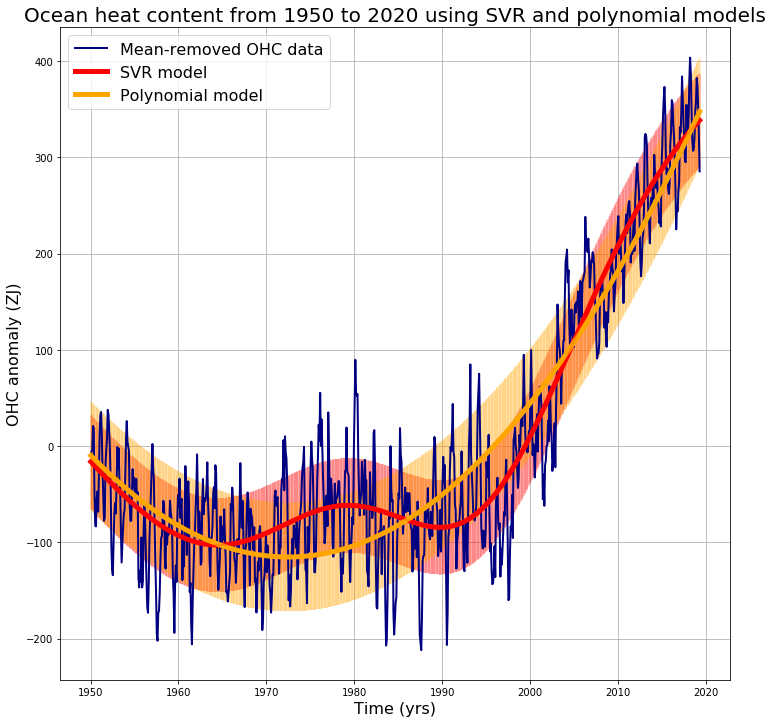

In [0]:
plt.figure(figsize=(12,12))
plt.xlabel('Time (yrs)',fontsize=16)
plt.ylabel('OHC anomaly (ZJ)',fontsize=16)
plt.title('Ocean heat content from 1950 to 2020 using SVR and polynomial models', fontsize=20)

plt.plot(time2,OHCmean,color='navy',linewidth=2,label='Mean-removed OHC data')

plt.plot(time2, y_hat,linewidth=5, color = 'red', label='SVR model')
plt.errorbar(time2, y_hat, rmse, alpha=0.25, color = 'red')

plt.plot(time2,f(df['newTime']),color='orange',linewidth=5,label='Polynomial model')
plt.errorbar(time2,f(df['newTime']),rmse_pol,color='orange',alpha=0.25)



plt.grid()
plt.legend(loc='best',fontsize=16)
plt.show()

In [0]:
OHC_2D = rho*cp*integral.sum(axis=1) #sum only on the z-axis
OHC_2D_mean = (OHC_2D-OHC_2D.sel(time=slice('1981','2010')).mean()).mean(dim='time')*10**(-21) ##Mean without the 1981-2010 baseline, and transformation into ZJ
OHC_2D_mean.load()

<xarray.DataArray (lat: 173, lon: 360)>
array([[-36.85343156, -36.85343156, -36.85343156, ..., -36.85343156,
        -36.85343156, -36.85343156],
       [-36.85343156, -36.85343156, -36.85343156, ..., -36.85343156,
        -36.85343156, -36.85343156],
       [-36.85343156, -36.85343156, -36.85343156, ..., -36.85343156,
        -36.85343156, -36.85343156],
       ...,
       [ 22.33330319,  22.33344758,  22.33362638, ...,  22.332328  ,
         22.33248756, -36.85343156],
       [ 22.32985841,  22.32989919,  22.32995857, ...,  26.29737225,
         26.29747919, -36.85343156],
       [-36.85343156, -36.85343156, -36.85343156, ..., -36.85343156,
        -36.85343156,  22.33005707]])
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0

<Figure size 432x288 with 0 Axes>

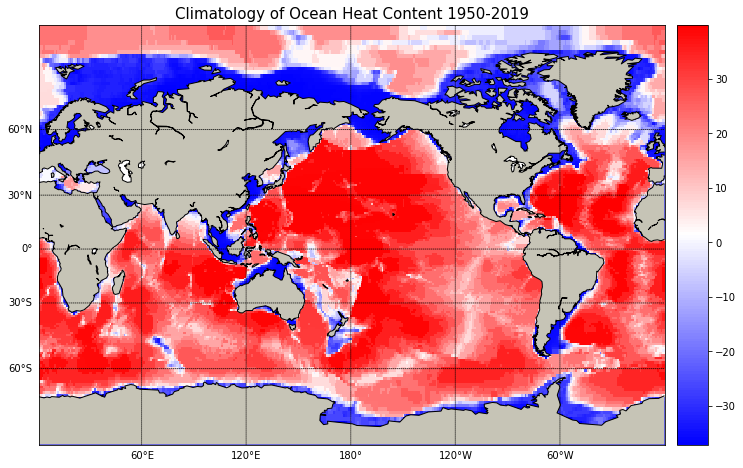

In [0]:
# set up the figure
plt.figure()

fig=plt.figure(figsize=(12, 12) ) geoscience
 geoscience
# Miller projection: geoscience*
m=Basemap(projection='mill',lat_ts geoscience=10,llcrnrlon=lon.min(), \
  urcrnrlon=lon.max(),llcrnrlat=la geosciencet.min(),urcrnrlat=lat.max(), \
  resolution='c') geoscience
 geoscience
# convert the lat/lon values to x/y projections.

x, y = m(*np.meshgrid(lon,lat))

# plot the field using the fast pcolormesh routine 
# set the colormap to jet.

m.pcolormesh(x,y,OHC_2D_mean,cmap=plt.cm.bwr)
cmap = m.colorbar(location='right',values=np.arange(np.min(OHC_2D_mean),np.max(OHC_2D_mean),0.5))
# Add a coastline and axis values.

m.drawcoastlines()
m.fillcontinents(color=(198/255, 196/255, 182/255))
#m.drawmapboundary()
m.drawparallels(np.arange(-90.,90.,30.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])

# Add a colorbar and title, and then show the plot.

plt.title('Climatology of Ocean Heat Content 1950-2019', fontsize=15);